In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('NYCTaxiFares.csv')

In [3]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [4]:
df.shape #120k records with 8 features

(120000, 8)

In [5]:
#let's see the features in the dataset
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [6]:
#do analysis on pickup_datetime. the pickup_datetime is in UTC timezone. We know NYC works in EST time zone, so we need to make changes to reflect that
#UTC to EST: UTC is 4 hours ahead of EST, so we will subtract 4 hours
import datetime

Performing Feature Engineering with respect to Datetime

In [7]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['pickup_datetime']

0        2010-04-19 08:17:56+00:00
1        2010-04-17 15:43:53+00:00
2        2010-04-17 11:23:26+00:00
3        2010-04-11 21:25:03+00:00
4        2010-04-17 02:19:01+00:00
                    ...           
119995   2010-04-18 14:33:03+00:00
119996   2010-04-23 10:27:48+00:00
119997   2010-04-18 18:50:40+00:00
119998   2010-04-13 08:14:44+00:00
119999   2010-04-17 16:00:14+00:00
Name: pickup_datetime, Length: 120000, dtype: datetime64[ns, UTC]

In [8]:
#Subtracting UTC by 4 hours to get EST times. We will use timedelta
df['pickup_datetime'] = df['pickup_datetime'] - datetime.timedelta(hours=4)
df['pickup_datetime']

0        2010-04-19 04:17:56+00:00
1        2010-04-17 11:43:53+00:00
2        2010-04-17 07:23:26+00:00
3        2010-04-11 17:25:03+00:00
4        2010-04-16 22:19:01+00:00
                    ...           
119995   2010-04-18 10:33:03+00:00
119996   2010-04-23 06:27:48+00:00
119997   2010-04-18 14:50:40+00:00
119998   2010-04-13 04:14:44+00:00
119999   2010-04-17 12:00:14+00:00
Name: pickup_datetime, Length: 120000, dtype: datetime64[ns, UTC]

Our dependent feature is 'fare_amount.'

In [9]:
df['Year'] = df['pickup_datetime'].dt.year #get the year from the pickup_datetime
df['Month'] = df['pickup_datetime'].dt.month #get the month from the pickup_datetime
df['Day'] = df['pickup_datetime'].dt.day #get the day from the pickup_datetime
df['Hours'] = df['pickup_datetime'].dt.hour #get the hours from the pickup_datetime
df['Minutes'] = df['pickup_datetime'].dt.minute #get the day from the pickup_datetime

In [10]:
df.shape #from the cell, 5 new rows have been added with respect to datetime

(120000, 13)

Generally, peak hours are 9-11 AM, and the rides will decrease during the afternoons. Based on the number of rides, we will try to figure out the time of the day.

In [11]:
import numpy as np

In [12]:
# checking for values in the morning time
df['morning_night']=np.where(df['Hours']<12, 0, 1) #if we have the morning time, the values will be 0 else 1

In [13]:
#now pickup_datetime is not relevant since we have extracted all the time information
df.drop('pickup_datetime', axis = 1, inplace = True)

In [14]:
df.head()

,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Day,Hours,Minutes,morning_night
0,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2010,4,19,4,17,0
1,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,2010,4,17,11,43,0
2,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,2010,4,17,7,23,0
3,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,2010,4,11,17,25,1
4,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,2010,4,16,22,19,1


Checking for latitudes and longitudes: refering to article: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html
The Haversine (or great circle) distance is the angular distance between two points on the surface of a sphere. The first coordinate of each point is assumed to be the latitude, the second is the longitude, given in radians. The dimension of the data must be 2.

In [15]:
#compute haversine distance between pickup_longitude, pickup_latitude and dropoff_longitude, dropoff_latitude
#make functions to compute the haversine distance on earth between the location points

def haversine(df):

    #Calculating the great circle distance between two points on earth specified in decimal degrees

    latitude_1 = np.radians(df['pickup_latitude'])
    latitude_2 = np.radians(df['dropoff_latitude'])

    distance_latitude = np.radians(df['dropoff_latitude'] - df['pickup_latitude'])
    distance_longitude = np.radians(df['dropoff_longitude'] - df['pickup_longitude'])

    #based on haversine formula

    arcsin = np.sin(distance_latitude/2)**2 + np.cos(latitude_1)*np.cos(latitude_2)*np.sin(distance_longitude/2)**2

    c = 2*np.arctan2(np.sqrt(arcsin), np.sqrt(1-arcsin))

    r = 6371 #Radius of earth in kilometers

    return c*r



In [16]:
df['Total distance'] = haversine(df)
df

,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Day,Hours,Minutes,morning_night,Total distance
0,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2010,4,19,4,17,0,2.126312
1,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,2010,4,17,11,43,0,1.392307
2,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,2010,4,17,7,23,0,3.326763
3,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,2010,4,11,17,25,1,1.864129
4,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,2010,4,16,22,19,1,7.231321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,15.3,1,-73.955857,40.784590,-73.981941,40.736789,1,2010,4,18,10,33,0,5.751348
119996,15.3,1,-73.996329,40.772727,-74.049890,40.740413,1,2010,4,23,6,27,0,5.767444
119997,12.5,1,-73.988574,40.749772,-74.011541,40.707799,3,2010,4,18,14,50,1,5.052523
119998,4.9,0,-74.004449,40.724529,-73.992697,40.730765,1,2010,4,13,4,14,0,1.208923


In [17]:
#Now, dropping the pickup and drop off latitudes and longitudes since we now have the total distance between pickup and drop off locations in kilometers
df.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis = 1, inplace = True)
df.head()

,fare_amount,fare_class,passenger_count,Year,Month,Day,Hours,Minutes,morning_night,Total distance
0,6.5,0,1,2010,4,19,4,17,0,2.126312
1,6.9,0,1,2010,4,17,11,43,0,1.392307
2,10.1,1,2,2010,4,17,7,23,0,3.326763
3,8.9,0,1,2010,4,11,17,25,1,1.864129
4,19.7,1,1,2010,4,16,22,19,1,7.231321


Now, feature engineering is completed. We will create the regression and classification models.
For regression, we will predict fare_amount. For classification, we will predict fare_class.

## Regression Model to Predict the Fare Rate

In [18]:
X = df.iloc[:,1:] #since fair_amount is the dependent feature, which is also the first feature in the dataset, the rest of the features are independent features
y = df.iloc[:,0] #fair_amount is the dependent feature, so it is our 'y'

In [19]:
##Feature Importance using ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
model = ExtraTreesRegressor()
model.fit(X,y)

ExtraTreesRegressor()

Taking the top 7 most important features and plotting them using bar plot

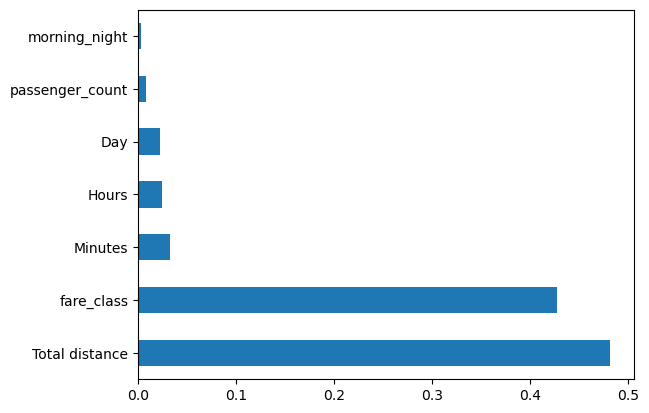

In [20]:
feature_imp = pd.Series(model.feature_importances_, index = X.columns)
feature_imp.nlargest(7).plot(kind = 'barh')
plt.show() #total_distance and fare_class are the most important features

In [21]:
X.head()

,fare_class,passenger_count,Year,Month,Day,Hours,Minutes,morning_night,Total distance
0,0,1,2010,4,19,4,17,0,2.126312
1,0,1,2010,4,17,11,43,0,1.392307
2,1,2,2010,4,17,7,23,0,3.326763
3,0,1,2010,4,11,17,25,1,1.864129
4,1,1,2010,4,16,22,19,1,7.231321


In [22]:
y.head()

0     6.5
1     6.9
2    10.1
3     8.9
4    19.7
Name: fare_amount, dtype: float64

In [23]:
#split data into train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

Use XGBoost Regressor to make predictions:

In [24]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [25]:
import xgboost

In [27]:
xgboost_reg = xgboost.XGBRegressor()
xgboost_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [28]:
y_pred = xgboost_reg.predict(X_test)

In [29]:
import matplotlib.pyplot as pyplot
%matplotlib inline

/var/folders/qf/7j3lvnwx0xn_ltwl3rkzpt_w0000gn/T/ipykernel_18266/4252741255.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test - y_pred)


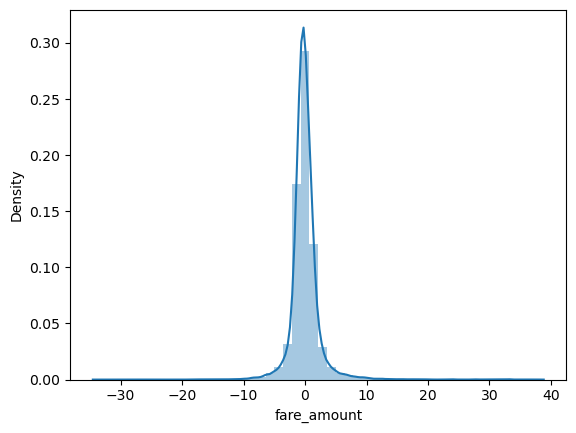

In [36]:
import seaborn as sns
sns.distplot(y_test - y_pred)
plt.show() #the model is pretty good

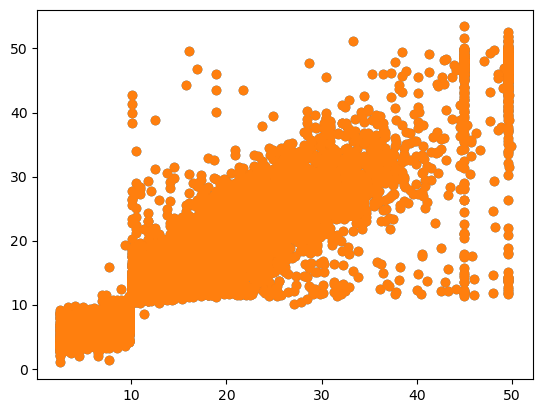

In [39]:
plt.scatter(y_test, y_pred)
plt.show()

In [44]:
from sklearn import metrics
print('R square:', np.sqrt(metrics.r2_score(y_test, y_pred)))
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R square: 0.9379037668296871
MAE: 1.4181402545239528
MSE: 6.883956187783126
RMSE: 2.62372944256513


## Hyperparameter Tuning

In [45]:
from sklearn.model_selection import RandomizedSearchCV

In [46]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
print(n_estimators)

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]


In [47]:
#Randomized Search CV
#Number of trees in XGBoost
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
#Various learning rate parameters
learning_rate = ['0.05','0.1','0.2','0.3','0.5','0.6']
#Max number of tree levels
max_depth = [int(x) for x in np.linspace(start = 5, stop = 30, num = 6)]
#subsample parameter values
subsample = [0.7, 0.6, 0.8]
#minimum child weight parameters
min_child_weight = [3, 4, 5, 6, 7]

In [48]:
#create random grid
random_grid = {'n_estimators': n_estimators, 'learning_rate': learning_rate, 'max_depth': max_depth, 'subsample': subsample, 'min_child_weight': min_child_weight}

In [49]:
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'learning_rate': ['0.05', '0.1', '0.2', '0.3', '0.5', '0.6'], 'max_depth': [5, 10, 15, 20, 25, 30], 'subsample': [0.7, 0.6, 0.8], 'min_child_weight': [3, 4, 5, 6, 7]}


In [50]:
#Use random grid to find the best hyperparameters
#Create base model to hypertune
xgboost_reg = xgboost.XGBRegressor()

In [51]:
#Random search of parameters across 100 different combinations using 3 fold cross validation
xg_random = RandomizedSearchCV(estimator = xgboost_reg, param_distributions = random_grid, scoring = 'neg_mean_squared_error', n_iter = 5, cv = 5, verbose = 2, random_state = 42, n_jobs = 1)

In [52]:
xg_random.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END learning_rate=0.05, max_depth=25, min_child_weight=6, n_estimators=1100, subsample=0.8; total time=  23.5s
[CV] END learning_rate=0.05, max_depth=25, min_child_weight=6, n_estimators=1100, subsample=0.8; total time=  23.6s
[CV] END learning_rate=0.05, max_depth=25, min_child_weight=6, n_estimators=1100, subsample=0.8; total time=  22.3s
[CV] END learning_rate=0.05, max_depth=25, min_child_weight=6, n_estimators=1100, subsample=0.8; total time=  21.5s
[CV] END learning_rate=0.05, max_depth=25, min_child_weight=6, n_estimators=1100, subsample=0.8; total time=  26.1s
[CV] END learning_rate=0.5, max_depth=30, min_child_weight=7, n_estimators=900, subsample=0.8; total time=  24.1s
[CV] END learning_rate=0.5, max_depth=30, min_child_weight=7, n_estimators=900, subsample=0.8; total time=  22.8s
[CV] END learning_rate=0.5, max_depth=30, min_child_weight=7, n_estimators=900, subsample=0.8; total time=  22.1s
[CV] END learning_

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_iter=5, n_jobs=1,
                   param_distributions={'learning_rate': ['0.05', '0.1', '0.2',
                                                          '0.3', '0.5', '0.6'],
                                        'max_depth': [5, 10, 15, 20, 25, 30],
                                        'min_child_weight': [3, 4, 5, 6, 7],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200],
                                        'subsample': [0.7, 0.6, 0.8]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [53]:
xg_random.best_params_

{'subsample': 0.8,
 'n_estimators': 1100,
 'min_child_weight': 6,
 'max_depth': 25,
 'learning_rate': '0.05'}

In [54]:
y_pred = xg_random.predict(X_test)

/var/folders/qf/7j3lvnwx0xn_ltwl3rkzpt_w0000gn/T/ipykernel_18266/523175245.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test - y_pred)


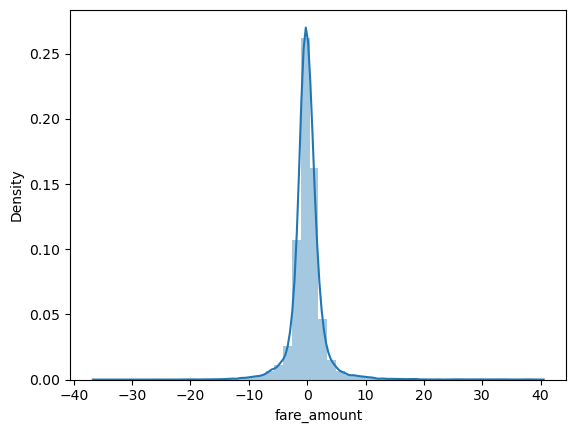

In [55]:
sns.distplot(y_test - y_pred)
plt.show()

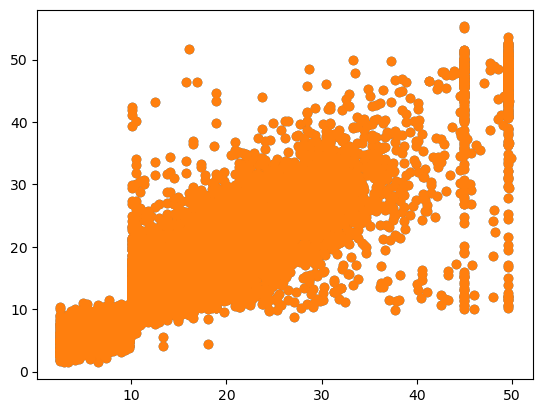

In [57]:
plt.scatter(y_test, y_pred)
plt.show()

In [58]:
from sklearn import metrics
print('R square:', np.sqrt(metrics.r2_score(y_test, y_pred)))
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R square: 0.9185939291277803
MAE: 1.6680666083341174
MSE: 8.934710685572046
RMSE: 2.9890986409906324


## Artificial Neural Networks (Regression Problem)

In [59]:
X_train.head()

,fare_class,passenger_count,Year,Month,Day,Hours,Minutes,morning_night,Total distance
40090,1,1,2010,4,12,16,17,1,3.181725
90425,0,2,2010,4,18,7,39,0,1.528133
63492,0,1,2010,4,11,18,53,1,4.020180
19581,1,1,2010,4,21,20,51,1,6.338458
39057,1,1,2010,4,14,16,46,1,6.823749


In [60]:
y_train.head()

40090    17.7
90425     4.9
63492     8.1
19581    17.7
39057    15.3
Name: fare_amount, dtype: float64

In [61]:
X_train.shape[1]

9

In [62]:
#Import the Keras libraries and packages
import tensorflow.keras
from tensorflow.keras.models import Sequential #wrapper wraps neural network
from tensorflow.keras.layers import Dense, LeakyReLU, PReLU, ELU, Dropout #dense layer helps create nodes in the hidden layers. sequential represents 
# a one-direction neural network

In [65]:
ann_model = Sequential()

#Input layer
ann_model.add(Dense(128, kernel_initializer = 'normal', input_dim = X_train.shape[1], activation = 'relu')) #to have 128 hidden nodes in the hidden layers. 

#Hidden layers
ann_model.add(Dense(256, kernel_initializer = 'normal', activation = 'relu'))
ann_model.add(Dense(256, kernel_initializer = 'normal', activation = 'relu'))
ann_model.add(Dense(256, kernel_initializer = 'normal', activation = 'relu'))

#Output layer
ann_model.add(Dense(1, kernel_initializer = 'normal', activation = 'linear')) #1 output node because this is regression problem. Use relu and not sigmoid since this is not classification

In [66]:
#Compile network
ann_model.compile(loss = 'mean_absolute_error', optimizer = 'adam', metrics = ['mean_absolute_error'])
ann_model.summary()

#fit the model to the training set
model_history = ann_model.fit(X_train, y_train, validation_split = 0.33, batch_size = 10, epochs = 20)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 128)            │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,145 (649.00 KB)

 Trainable params: 166,145 (649.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
5628/5628 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 3.0538 - mean_absolute_error: 3.0538 - val_loss: 2.2619 - val_mean_absolute_error: 2.2619
Epoch 2/20
5628/5628 ━━━━━━━━━━━━━━━━━━━━ 5s 949us/step - loss: 1.7656 - mean_absolute_error: 1.7656 - val_loss: 1.6193 - val_mean_absolute_error: 1.6193
Epoch 3/20
5628/5628 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 1.7226 - mean_absolute_error: 1.7226 - val_loss: 1.6417 - val_mean_absolute_error: 1.6417
Epoch 4/20
5628/5628 ━━━━━━━━━━━━━━━━━━━━ 5s 926us/step - loss: 1.6804 - mean_absolute_error: 1.6804 - val_loss: 1.6018 - val_mean_absolute_error: 1.6018
Epoch 5/20
5628/5628 ━━━━━━━━━━━━━━━━━━━━ 5s 974us/step - loss: 1.6440 - mean_absolute_error: 1.6440 - val_loss: 1.5482 - val_mean_absolute_error: 1.5482
Epoch 6/20
5628/5628 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 1.6638 - mean_absolute_error: 1.6638 - val_loss: 1.5850 - val_mean_absolute_error: 1.5850
Epoch 7/20
5628/5628 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 1.6102 - mean_absolu

## ANN Model Evaluation

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


/var/folders/qf/7j3lvnwx0xn_ltwl3rkzpt_w0000gn/T/ipykernel_18266/227567198.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test.values.reshape(-1, 1) - predictions)


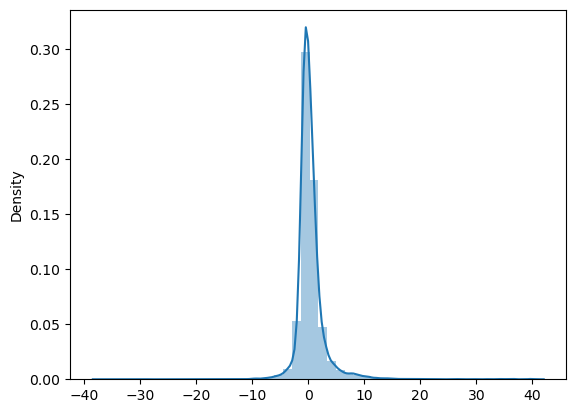

In [67]:
predictions = ann_model.predict(X_test)
sns.distplot(y_test.values.reshape(-1, 1) - predictions)
plt.show()

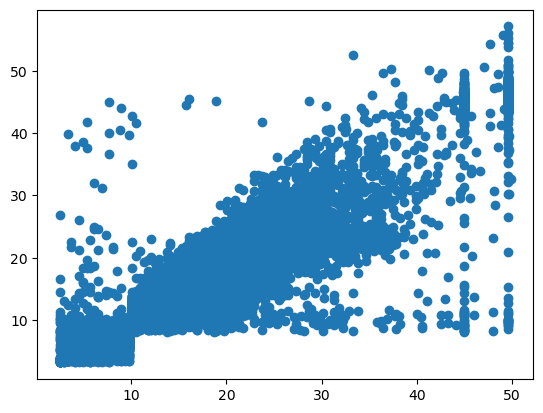

In [68]:
plt.scatter(y_test, predictions)
plt.show()

In [69]:
from sklearn import metrics
print('R square:', np.sqrt(metrics.r2_score(y_test, predictions)))
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

R square: 0.9208996791424837
MAE: 1.4723344711184503
MSE: 8.692076976175326
RMSE: 2.9482328565049483


## TPOTRegressor Automated Library

TPOTRegressor Automated Library determines the algorithm suitable for this problem by using genetic algorithm. From 'n' number of generations, the automated library creates offsprings of models, post which it selects the best algorithm suitable for this problem.

In [70]:
pip install tpot

  Preparing metadata (setup.py) ... done
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11939 sha256=882a286d015d0cd5e71b77f82b7a1dae0b2dba556f1783f6656f05c3c7c3bfb2
  Stored in directory: /Users/palakprashant/Library/Caches/pip/wheels/10/10/63/c3c98c9859d2aa59553536cc2ea005d3c9c39e214ab4fd614c
Successfully built stopit
Note: you may need to restart the kernel to use updated packages.


In [71]:
from tpot import TPOTRegressor

/opt/anaconda3/lib/python3.12/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [ ]:
tpot_reg=TPOTRegressor()
tpot_reg.fit(X_train, y_train)

In [ ]:
tpot = TPOTRegressor(generations = 1, population_size = 10, verbosity = 2, random_state = 42) #create 10 offsprings of models
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_taxiFaredocumentation.py') #creates whole generated pipeline

In [ ]:
import numpy as np
import pandas a spd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import ElasticNetCV
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive
from slearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union

tpot_data = pd.read_csv('final_data.csv', sep = ',', dtype = np.float64)
features = tpot_data.drop('fare_amount', axis = 1)
training_features, testing_features, training_target, testing_target = train_test_split(features, tpot_data['fare_amount'], random_state = 42)

In [ ]:
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=ExtraTreesRegressor(bootstrap = False, max_features = 0.95, min_samples_leaf = 10, min_samples_split=5, n_estimators=100)),
    ElasticNetCV(l1_ratio = 0.45, tol=0.001)
)

#fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

In [ ]:
results

In [ ]:
training_target

In [ ]:
import seaborn as sns
sns.distplot(testing_target.values - results)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(testing_target, results)
plt.show()

In [ ]:
from sklearn import metrics
print('R square:', np.sqrt(metrics.r2_score(testing_target, results)))
print('MAE:', metrics.mean_absolute_error(testing_target, results))
print('MSE:', metrics.mean_squared_error(testing_target, results))
print('RMSE:', np.sqrt(metrics.mean_squared_error(testing_target, results)))